In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from extra_models.object_detector import ObjectDetector
import matplotlib.pyplot as plt
from model_trainer import create_train_dataset

In [2]:
%matplotlib inline

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [4]:
data_dir = 'data/val'
img_size = (640,480)
class_names = ['food']
bbox_sizes = [(25,25)]

In [5]:
ds = create_train_dataset(data_dir, img_size, class_names, bbox_sizes, val_data=True)

In [6]:
backbone_f = 'hr_5_3_8'
intermediate_filters = 256
kernel_size = 16
stride = 8
num_classes = len(class_names) + 1

In [7]:
test_model = ObjectDetector(
    backbone_f,
    intermediate_filters,
    kernel_size,
    stride,
    img_size,
    num_classes,
)

In [8]:
load_dir = 'savedmodels/hr538_m_f1/92'
test_model.load_weights(load_dir)

tf.Tensor(
[[   43.334118  -128.76941    -90.796616 ... -1903.8484     232.00067
   -433.09033 ]
 [   49.61861   -174.79536   -105.042206 ... -1976.1418     235.81015
   -428.9262  ]
 [   45.452473  -151.03868    -96.747635 ... -1867.6067     215.74599
   -404.83466 ]
 ...
 [  103.863556  -347.23465   -227.79468  ... -4182.62       474.18036
   -881.89575 ]
 [   98.256454  -334.1687    -215.69904  ... -3959.5537     461.32553
   -850.16846 ]
 [   82.99402   -327.2084    -196.15617  ... -3339.7458     410.70932
   -735.3691  ]], shape=(79, 36), dtype=float32)
(2000, 4)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(
[[   42.463352  -126.37712    -89.99368  ... -1869.072      228.44225
   -425.18958 ]
 [   48.230328  -168.91626   -102.86159  ... -1928.7175     229.52655
   -418.46344 ]
 [   44.676884  -146.56679    -94.83263  ... -1834.4154     210.88127
   -397.94284 ]
 ...
 [  103.629196  -348.79535   -229.07945  ... -4198.8784     477.20163
   -886.5392  ]
 [   98.08418   -336.8148

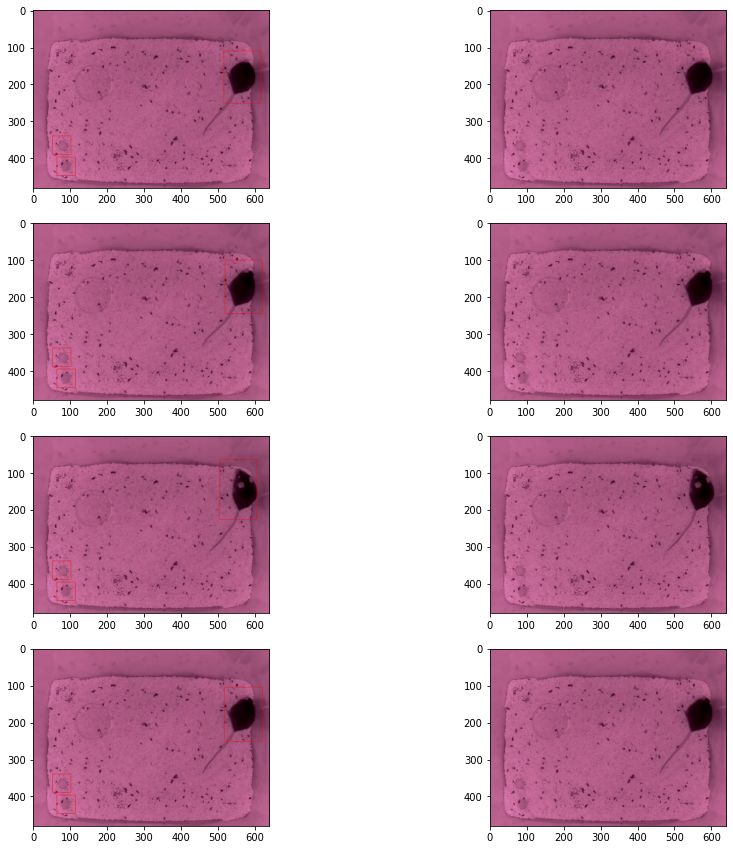

In [9]:
samples = ds.take(4).as_numpy_iterator()
fig = plt.figure(figsize=(15,15))
for i in range(4):
    sample = next(samples)
    image, gt_box, _ = sample
    rois, probs = test_model(image, training=False)
    test_image = image[0].copy()
    gt_image = image[0].copy()
    gt_box = gt_box[0]
    h,w = np.subtract(gt_image.shape[:2],1)
    print(rois.shape)
    print(probs[30])
    for roi in rois.numpy():

        x1, y1, x2, y2 = (roi*np.array([w,h,w,h,])).astype(np.int64)
        test_image[y1,x1:x2] = [0,1,0]
        test_image[y2,x1:x2] = [0,1,0]
        test_image[y1:y2,x1] = [0,1,0]
        test_image[y1:y2,x2] = [0,1,0]
    for box in gt_box:
        x1, y1, x2, y2 = (box*np.array([w,h,w,h,])).astype(np.int64)
        gt_image[y1,x1:x2] = [1,0,0]
        gt_image[y2,x1:x2] = [1,0,0]
        gt_image[y1:y2,x1] = [1,0,0]
        gt_image[y1:y2,x2] = [1,0,0]

    ax = fig.add_subplot(4,2,2*i+1)
    ax.imshow(gt_image)
    ax = fig.add_subplot(4,2,2*i+2)
    ax.imshow(test_image)
plt.show()
